### Prepare your environment

import libraries you will use throughout the project.

In [101]:
# Python 3 environment libraries

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')

# Modeling
import statsmodels.api as sm

from scipy.stats import pearsonr
from scipy.stats import iqr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

### Data Acquisition

Acquire via a .csv file

In [102]:
path = './'

In [126]:
### Loading Dataset using 'properties_2016.csv'
dfproperties_2016 = pd.read_csv(path + 'properties_2016.csv')

In [104]:
### Loading Dataset using 'train_2016.csv'
dftrain_2016 = pd.read_csv(path + 'train_2016.csv')

In [105]:
### Creating data frame a
df_a = pd.DataFrame(dfproperties_2016, columns = [
      'bathroomcnt',
      'bedroomcnt',
      'calculatedfinishedsquarefeet',
      'fullbathcnt',
      'garagecarcnt',
      'regionidzip',
      'roomcnt',
      'yearbuilt',
      'taxvaluedollarcnt',
      'taxamount',
      'parcelid'])

In [106]:
### Creating data frame b
df_b = pd.DataFrame(dftrain_2016, columns = ['parcelid', 'logerror'])

In [107]:
### Joining the both a and b along the 'parcelid' value
df_join = pd.merge(df_a, df_b, on='parcelid')

### Sumarize Data

In [108]:
### Creating a summary with print statements
def summarize_df(df):
    print("\nRows & Columns:\n")
    print(df.shape)
    print("\nColumn Info:\n")
    print(df.info())
    print("\nFirst 5 rows:\n")
    print(df.head())
    print("\nLast 5 rows:\n")
    print(df.tail())
    print("\nMissing Values:\n")
    missing_vals = df.columns[df.isnull().any()]
    print(df.isnull().sum())
    print("\nSummary Stats:\n")
    print(df.describe())
    print("\nColumn IQR:\n")
    var_names = df.columns.values
    for var in var_names:
        print(var+":")
        print(iqr(df[var],axis=0))

In [109]:
summarize_df(df_join)


Rows & Columns:

(90275, 12)

Column Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 12 columns):
bathroomcnt                     90275 non-null float64
bedroomcnt                      90275 non-null float64
calculatedfinishedsquarefeet    89614 non-null float64
fullbathcnt                     89093 non-null float64
garagecarcnt                    29937 non-null float64
regionidzip                     90240 non-null float64
roomcnt                         90275 non-null float64
yearbuilt                       89519 non-null float64
taxvaluedollarcnt               90274 non-null float64
taxamount                       90269 non-null float64
parcelid                        90275 non-null int64
logerror                        90275 non-null float64
dtypes: float64(11), int64(1)
memory usage: 9.0 MB
None

First 5 rows:

   bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  fullbathcnt  \
0          2.5         3.0                 

### Data Preparation

Goal: leave this section with a dataset that is ready to be analyzed.

In [110]:
### Create a variable, colnames, that is a list of the column names.
variables = pd.DataFrame(df_join.columns, columns=['colnames'])
variables

,colnames
0,bathroomcnt
1,bedroomcnt
2,calculatedfinishedsquarefeet
3,fullbathcnt
4,garagecarcnt
5,regionidzip
6,roomcnt
7,yearbuilt
8,taxvaluedollarcnt
9,taxamount


In [111]:
### Replace Null Values
df_join = df_join.apply(lambda x: x.fillna(x.mean()),axis=0)

In [112]:
### Remove Outliers Using Z-Score
df_remove_outliers = df_join[(np.abs(stats.zscore(df_join)) < 3).all(axis=1)]

In [113]:
### Drop unnecessary columns
columns_to_remove = ['regionidzip', 
                     'taxamount', 
                     'fullbathcnt', 
                     'garagecarcnt', 
                     'roomcnt']
df_fixed = df_remove_outliers.drop(columns_to_remove, axis=1)

### Create a list of the independent variable name
df_fixed.columns.values

array(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'yearbuilt', 'taxvaluedollarcnt', 'parcelid', 'logerror'],
      dtype=object)

In [134]:
df_fixed.sort_values(['logerror'], ascending=True).sample(10)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,yearbuilt,taxvaluedollarcnt,parcelid,logerror
13992,3.0,4.0,2551.0,1967.0,1404540.0,10747565,-0.0932
36018,2.0,5.0,2521.0,1965.0,816723.0,17124512,-0.1358
56260,3.0,4.0,2806.0,2005.0,689000.0,17188158,0.0080
8314,2.0,4.0,2216.0,1955.0,330511.0,12215592,0.0953
72948,2.0,2.0,1054.0,1977.0,239560.0,14676808,0.0080
6306,2.0,3.0,2142.0,1933.0,592196.0,10907825,0.0630
57709,2.0,4.0,1817.0,1968.0,332488.0,11163313,0.0305
59771,1.0,1.0,610.0,1977.0,211901.0,12042894,0.0208
32926,3.0,4.0,2279.0,1984.0,438592.0,11166503,-0.0020
47121,2.0,3.0,1280.0,1923.0,263268.0,12205847,-0.0408


In [133]:
df_fixed.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,yearbuilt,taxvaluedollarcnt,parcelid,logerror
count,84800.000000,84800.000000,84800.000000,84800.000000,8.480000e+04,8.480000e+04,84800.000000
mean,2.189764,2.954575,1661.673807,1968.456669,3.972315e+05,1.294835e+07,0.007735
std,0.830325,1.019642,688.753279,23.293326,2.983931e+05,1.743571e+06,0.087009
min,0.000000,0.000000,2.000000,1898.000000,2.200000e+01,1.071174e+07,-0.471600
25%,2.000000,2.000000,1172.000000,1953.000000,1.944778e+05,1.153827e+07,-0.025300
50%,2.000000,3.000000,1512.000000,1969.000000,3.330000e+05,1.254638e+07,0.005000
75%,3.000000,4.000000,1992.000000,1986.000000,5.120000e+05,1.421750e+07,0.036300
max,5.000000,6.000000,4546.000000,2015.000000,2.121904e+06,1.730084e+07,0.494100


In [114]:
### Create a list of the independent variable names (aka attributes) and assign it to x_vars
x_vars = df_fixed.columns.values

In [115]:
### Clearly identify your dependent (target) variable
y = df_fixed.columns.values[6]

In [116]:
summarize_df(df_fixed)


Rows & Columns:

(84800, 7)

Column Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84800 entries, 0 to 90274
Data columns (total 7 columns):
bathroomcnt                     84800 non-null float64
bedroomcnt                      84800 non-null float64
calculatedfinishedsquarefeet    84800 non-null float64
yearbuilt                       84800 non-null float64
taxvaluedollarcnt               84800 non-null float64
parcelid                        84800 non-null int64
logerror                        84800 non-null float64
dtypes: float64(6), int64(1)
memory usage: 5.2 MB
None

First 5 rows:

   bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  yearbuilt  \
0          2.5         3.0                        1264.0     1986.0   
1          1.0         2.0                         777.0     1990.0   
2          2.0         3.0                        1101.0     1956.0   
3          1.5         2.0                        1554.0     1965.0   
4          2.5         4.0             

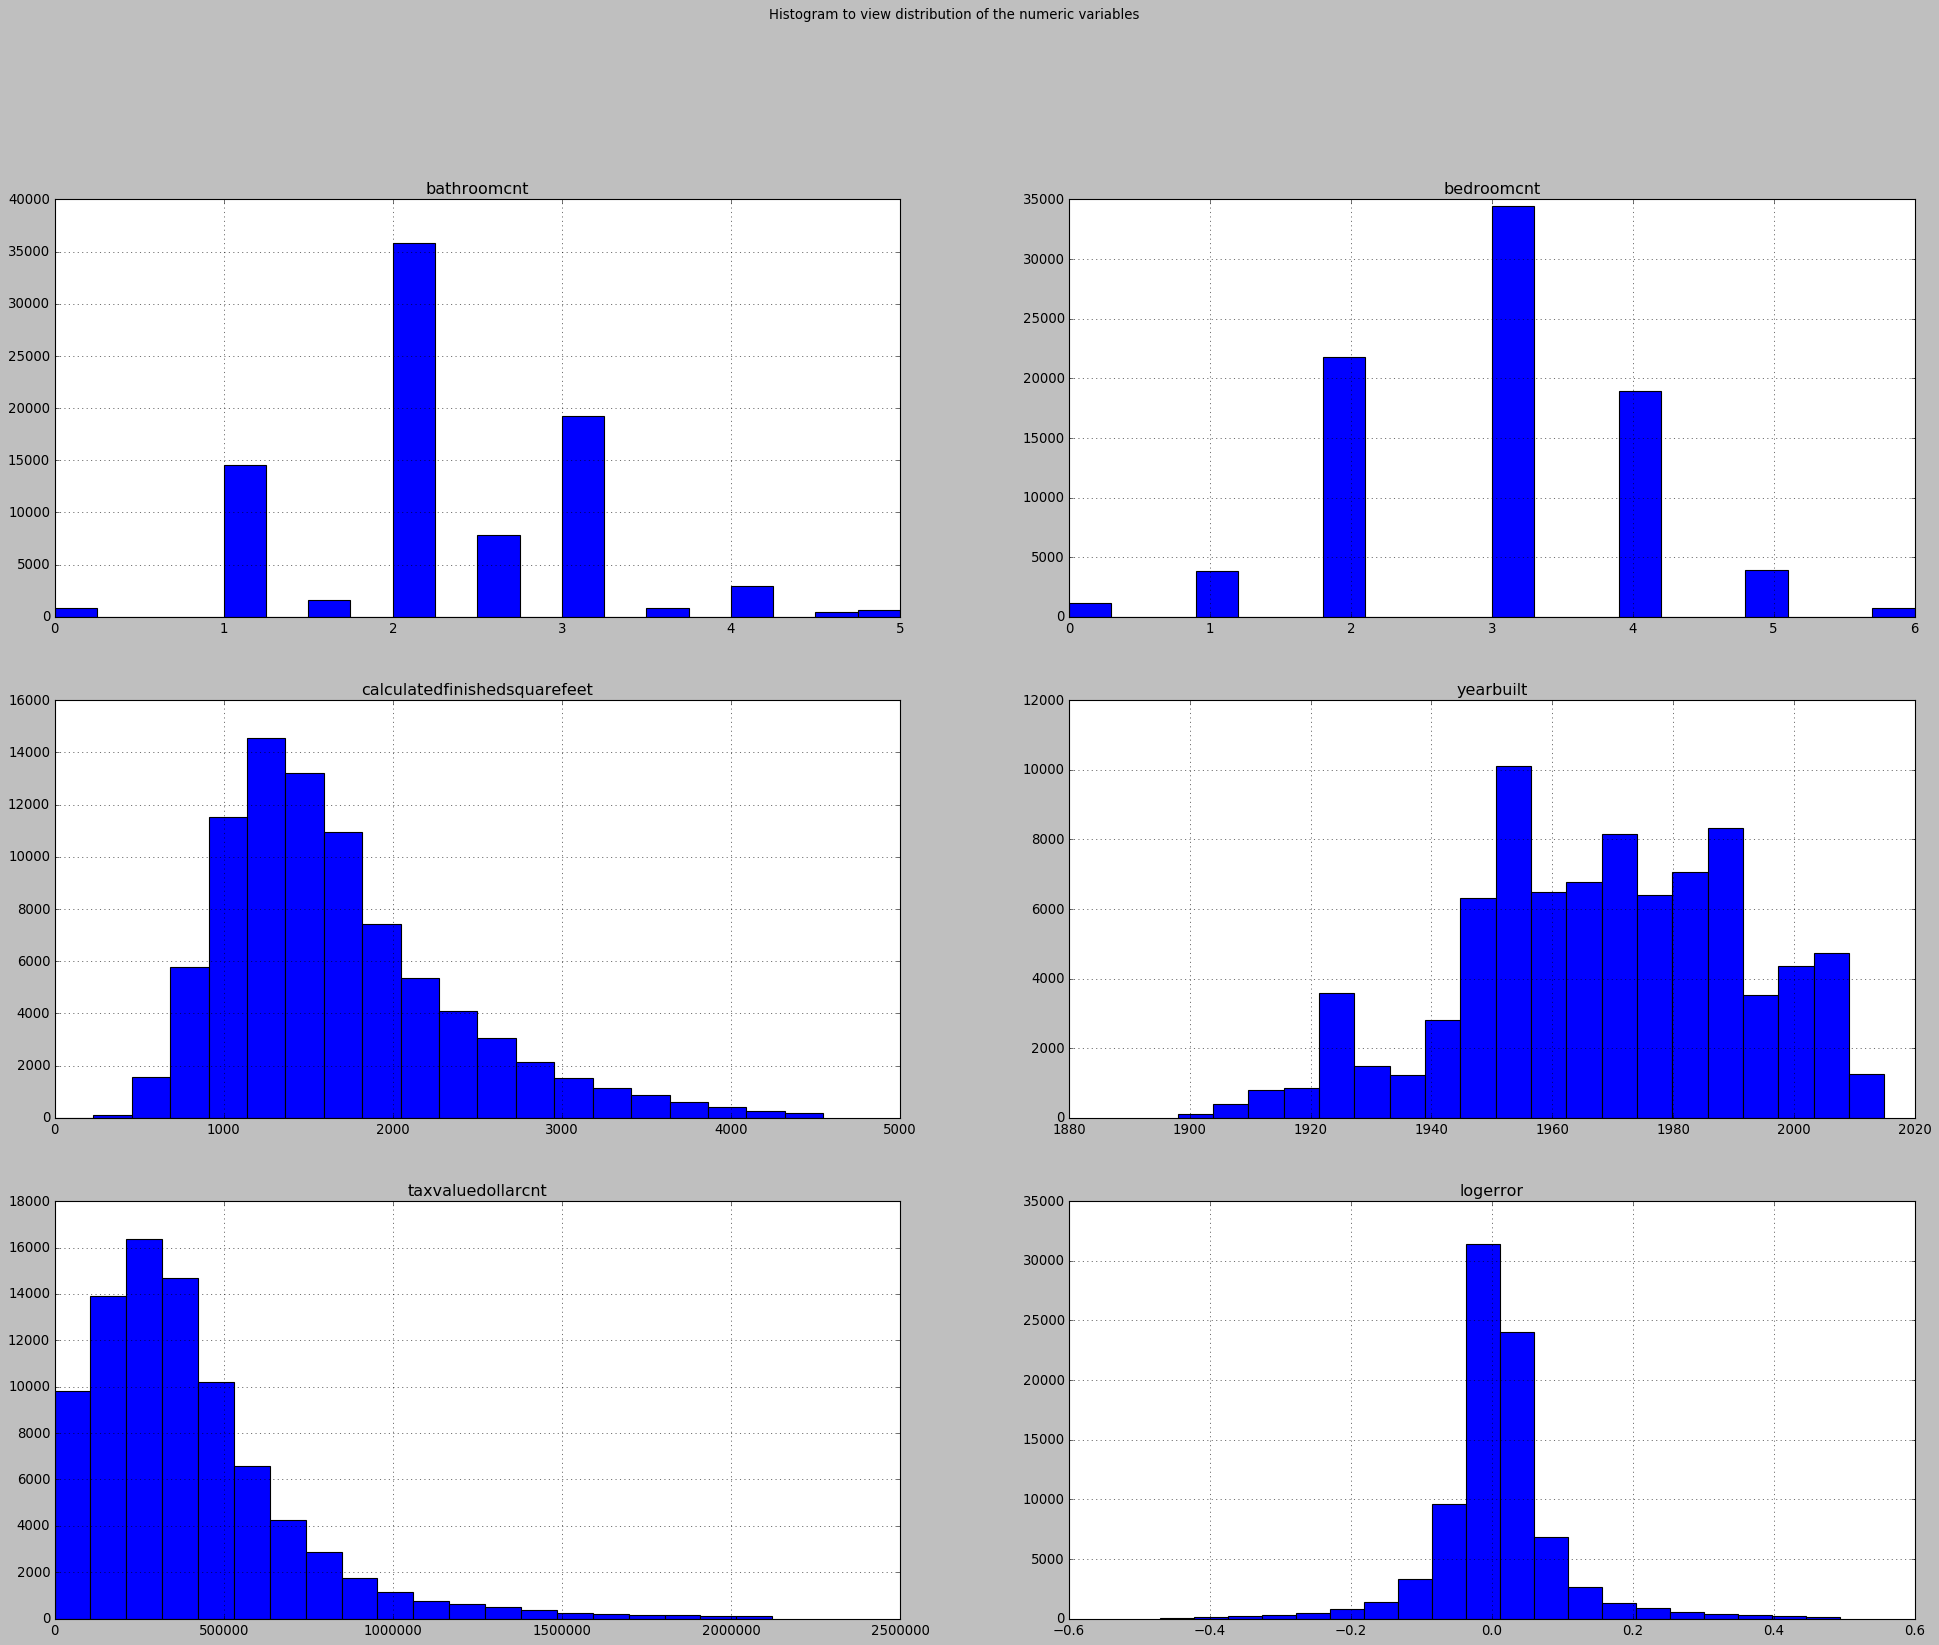

In [117]:
### View the distribution of the numeric variables with histograms
plt.figure(figsize=(30,30))
plt.suptitle('Histogram to view distribution of the numeric variables')

for i, col in enumerate(['bathroomcnt', 
                         'bedroomcnt', 
                         'calculatedfinishedsquarefeet',
                         'yearbuilt', 
                         'taxvaluedollarcnt', 
                         'logerror']):  
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df_fixed[col]  
    plt.subplot(4, 2, plot_number)
    plt.title(col)
    series.hist(bins=20, density=False, cumulative=False, log=False)

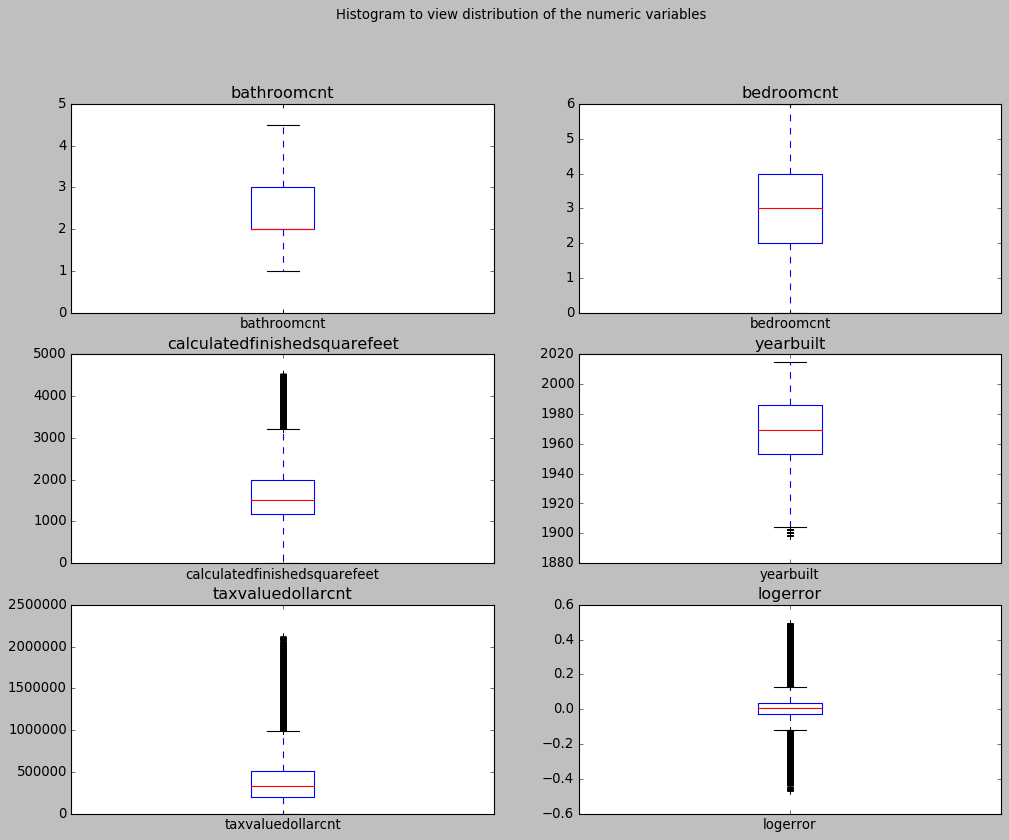

In [118]:
### View the distribution of the numeric variables with boxplots
plt.figure(figsize=(15,15))
plt.suptitle('Histogram to view distribution of the numeric variables')

for i, col in enumerate(['bathroomcnt', 
                         'bedroomcnt', 
                         'calculatedfinishedsquarefeet',
                         'yearbuilt', 
                         'taxvaluedollarcnt', 
                         'logerror']):  
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df_fixed[col]  
    plt.subplot(4, 2, plot_number)
    plt.title(col)
    series.plot.box()

### Data Exploration

Goal is to address each of the questions you posed in your planning & brainstorming through visual or statistical analysis.

In [119]:
### Split data into training and test datasets
X = df_fixed.drop(['logerror','parcelid'], axis=1)
y = df_fixed[['logerror']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [123]:
print("Test columns:  %s" % list(test.columns))
print("Test dimensions (rows, columns):", test.shape)

Test columns:  ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'taxvaluedollarcnt', 'logerror']
Test dimensions (rows, columns): (16960, 6)


<Figure size 800x640 with 0 Axes>

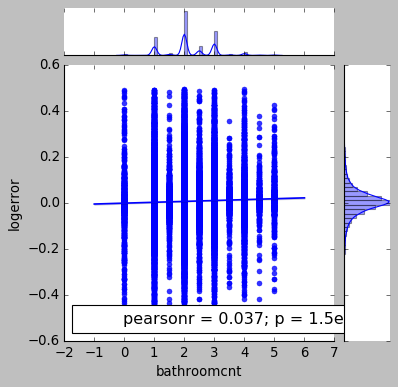

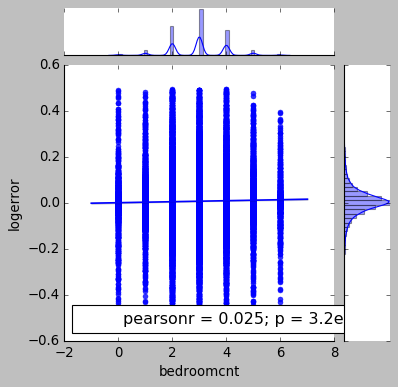

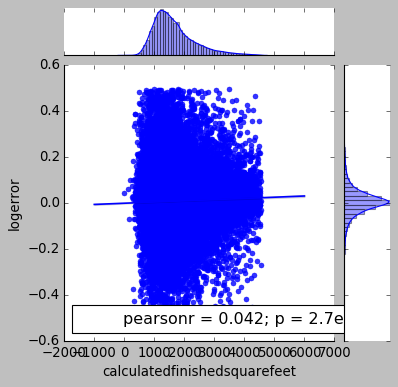

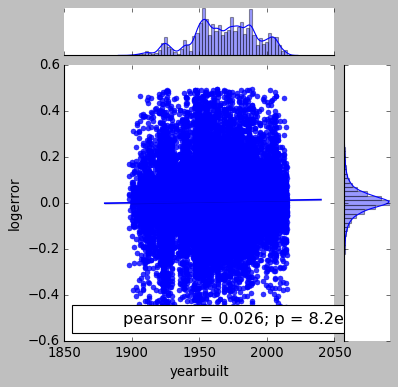

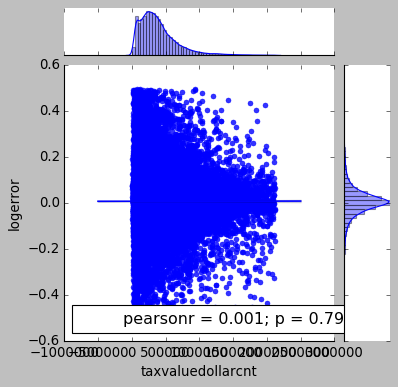

In [121]:
### Create a jointplot for each independent variable (normalized version) with the dependent variable.
plt.figure(figsize=(10, 8))

for i in range(0,5):
    j = sns.jointplot(x_vars[i], 'logerror', data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)

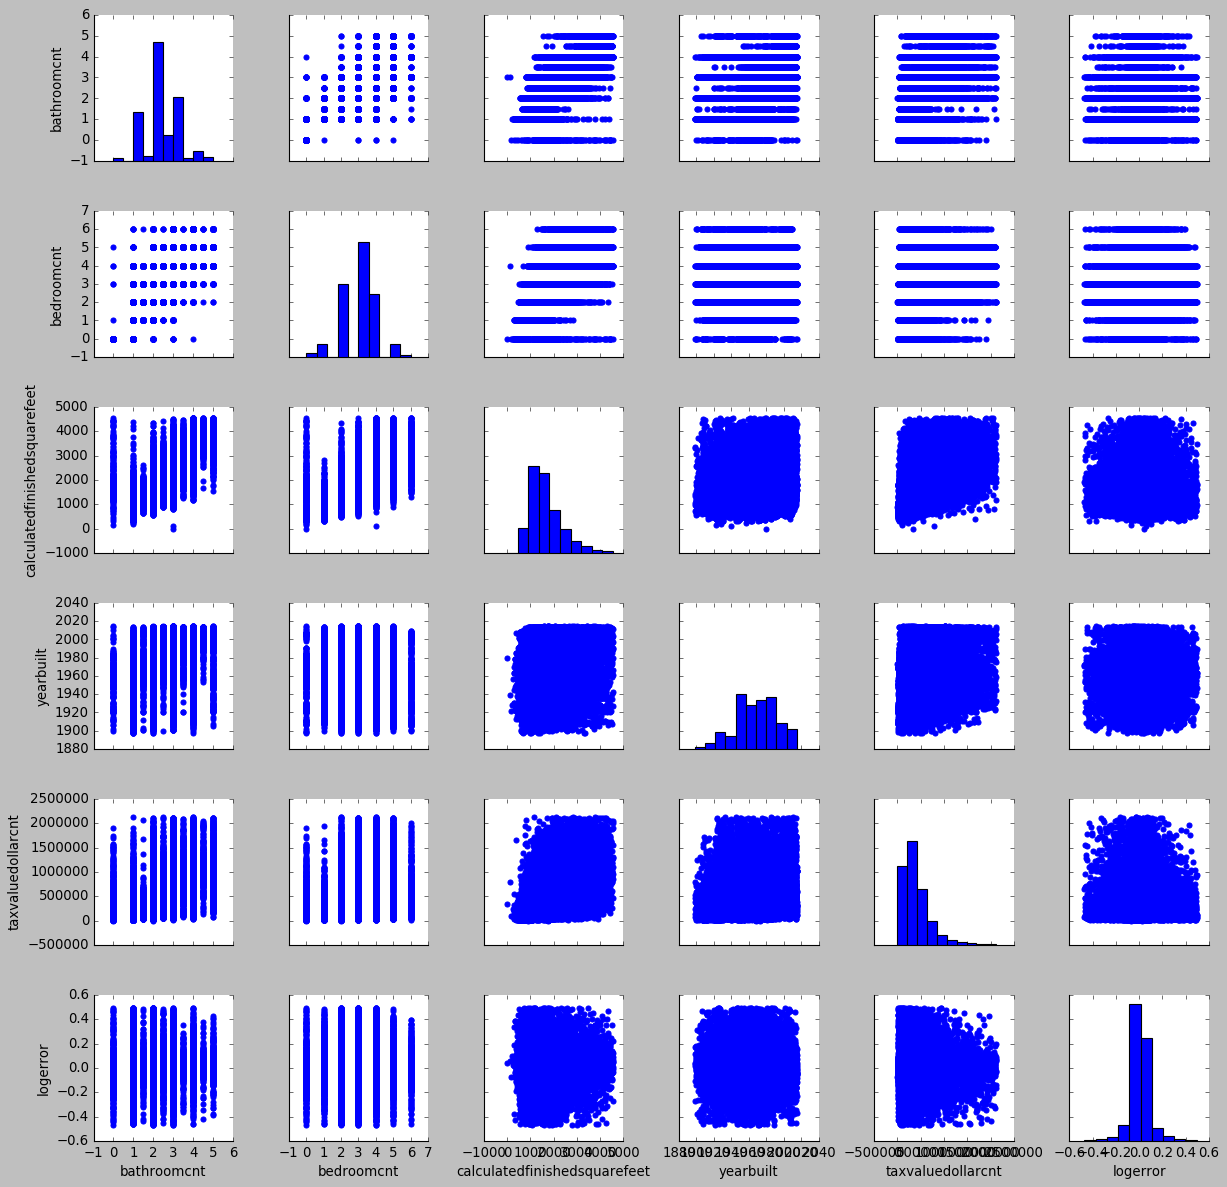

In [122]:
### Create a feature plot using seaborn's PairGrid() of the interaction between each variable (dependent + independent).
g = sns.PairGrid(train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);

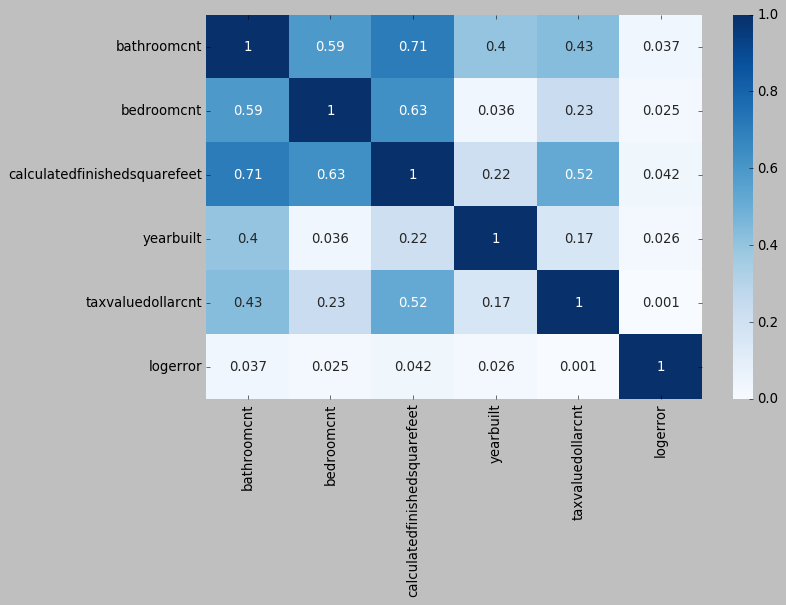

In [124]:
### Create a heatmap of the correlation between each variable pair.
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(), cmap='Blues', annot=True)

In [144]:
pd.value_counts(train['bathroomcnt'].values, sort=True)

2.0    28564
3.0    15382
1.0    11705
2.5     6309
4.0     2343
1.5     1290
0.0      693
3.5      691
5.0      494
4.5      369
dtype: int64

In [145]:
pd.value_counts(train['bedroomcnt'].values, sort=True)

3.0    27556
2.0    17488
4.0    15116
5.0     3176
1.0     3035
0.0      905
6.0      564
dtype: int64

In [129]:
### Is the logerror significantly different for homes with 3 bedrooms vs those with 5 or more bedrooms?
three_br = train[train.bedroomcnt == 3]
five_br = train[train.bedroomcnt >= 3]

from scipy.stats import ttest_ind
ttest_ind(three_br.logerror, five_br.logerror)

Ttest_indResult(statistic=-2.952943548771169, pvalue=0.003148584418341588)

In [142]:
### Do the same for another 2 samples you are interested in comparing (e.g. those with 1 bath vs. x baths)
one_ba = train[train.bathroomcnt <= 2]
four_ba = train[train.bathroomcnt >= 3]

from scipy.stats import ttest_ind
ttest_ind(one_ba.logerror, four_ba.logerror)

Ttest_indResult(statistic=-8.363763285558528, pvalue=6.20027143983218e-17)

### Data Modeling